In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error as mape,mean_absolute_error as mae
from keras import optimizers

# Prepare Data

In [2]:
cloud_cover = pd.read_csv(r"G:\My Drive\senior\mergefile_drop_na.csv",skipinitialspace = True)
cloud_cover = cloud_cover.rename(columns={"timestamp":"DateTime"})
cloud_cover

,DateTime,Eeg,Temperature,RH,Windspeed,cloud_cover
0,2021-11-16 11:15:00,389.3058,29.3306,68.9674,1.7412,0.990000
1,2021-11-16 11:20:00,386.4714,29.2626,69.6372,1.7202,0.989667
2,2021-11-16 11:25:00,362.6794,29.2746,70.6488,1.7378,0.993667
3,2021-11-16 11:30:00,304.7228,29.2650,70.6084,1.6944,0.987500
4,2021-11-16 11:35:00,297.6544,29.2550,70.7396,1.7838,0.989000
...,...,...,...,...,...,...
2975,2021-12-16 13:40:00,667.8462,32.0638,38.0598,1.7466,0.185000
2976,2021-12-16 13:45:00,655.7560,32.3906,37.1100,1.7442,0.182000
2977,2021-12-16 13:50:00,647.5236,32.3444,37.1282,1.7116,0.180000
2978,2021-12-16 13:55:00,635.4336,32.3944,37.2276,1.7612,0.169000


In [3]:
cloud_cover = cloud_cover.drop(columns=['Eeg'])

In [4]:
def lags_train_test(datax, datay, data, lags):
	X, y = [], []
	for i in range(lags, len(data)):
		X.append(datax[i-lags:i])
		y.append(datay[i])
	return np.array(X), np.array(y)

In [5]:
def Xtrain_ytrain(train,test,lags):
    sc = MinMaxScaler()
    train_x = sc.fit_transform(train)
    sc1 = MinMaxScaler()
    train_y = sc1.fit_transform(train[['cloud_cover']])
    # train
    X_train, y_train = lags_train_test(train_x,train_y, train, lags)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    print("X_train Shape :", X_train.shape)
    print("y_train Shape :", y_train.shape)

    #scale test
    columns = test[['Temperature','RH','Windspeed','cloud_cover']]
    dataset_total = pd.concat(([train,test]), axis=0)
    inputs = dataset_total[len(dataset_total) - len(test) - lags:].values
    inputs = pd.DataFrame(inputs, columns=columns.columns)
    test_x = sc.transform(inputs)
    test_y = sc1.transform(inputs[['cloud_cover']])
    # test
    X_test, y_test = lags_train_test(test_x,test_y, inputs, lags)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    print("X_test Shape : ", X_test.shape)
    print("y_test Shape : ", y_test.shape)
    return X_train, y_train, X_test, y_test, sc1

In [6]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [7]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [8]:
def plot_test(train,pred):
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['cloud_cover'], name = 'Actual'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['LSTM'], name = 'Predict'))
    fig2.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
    )


    fig2.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=2,
                        label="2.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=3,
                        label="3.zoom",
                        step="day",
                        stepmode="backward"),              

                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig2.show()

# Train/Test Model

In [9]:
train = cloud_cover[cloud_cover['DateTime'] < '2021-12-16 00:00:00']
test = cloud_cover[cloud_cover['DateTime'] >= '2021-12-16 00:00:00']

print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (2921, 5)
Test Shape (59, 5)


In [10]:
train

,DateTime,Temperature,RH,Windspeed,cloud_cover
0,2021-11-16 11:15:00,29.3306,68.9674,1.7412,0.990000
1,2021-11-16 11:20:00,29.2626,69.6372,1.7202,0.989667
2,2021-11-16 11:25:00,29.2746,70.6488,1.7378,0.993667
3,2021-11-16 11:30:00,29.2650,70.6084,1.6944,0.987500
4,2021-11-16 11:35:00,29.2550,70.7396,1.7838,0.989000
...,...,...,...,...,...
2916,2021-12-15 16:35:00,29.7842,57.2676,1.6910,0.245000
2917,2021-12-15 16:40:00,29.6908,56.1350,1.6476,0.214000
2918,2021-12-15 16:45:00,29.6822,56.8298,1.7884,0.311000
2919,2021-12-15 16:50:00,29.5512,57.3708,1.6884,0.250000


In [11]:
test

,DateTime,Temperature,RH,Windspeed,cloud_cover
2921,2021-12-16 09:10:00,26.3570,59.4630,1.8078,0.111
2922,2021-12-16 09:15:00,26.5138,57.7414,1.8068,0.094
2923,2021-12-16 09:20:00,26.7386,57.1244,1.8530,0.112
2924,2021-12-16 09:25:00,26.7556,56.6154,1.7632,0.123
2925,2021-12-16 09:30:00,26.9252,55.9558,1.5730,0.136
2926,2021-12-16 09:35:00,27.1718,55.0054,1.7632,0.154
2927,2021-12-16 09:40:00,27.2984,54.1164,1.7462,0.161
2928,2021-12-16 09:45:00,27.3976,53.6244,1.6644,0.156
2929,2021-12-16 09:50:00,27.4496,53.0188,1.7654,0.198
2930,2021-12-16 09:55:00,27.5436,52.6994,1.7786,0.281


In [12]:
train = train.set_index('DateTime')
test = test.set_index('DateTime')

## Lag 5

In [13]:
# X_train, y_train, X_test and y_test
X_train, y_train, X_test, y_test, sc = Xtrain_ytrain(train,test,5)

X_train Shape : (2916, 5, 4)
y_train Shape : (2916, 1)
X_test Shape :  (59, 5, 4)
y_test Shape :  (59, 1)


### Add frist layer: units = 50 and Add Dropout = 0.1

In [14]:
model_1 = Sequential()
model_1.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1],X_train.shape[2])))
model_1.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_1.compile(optimizer = opt, loss = 'mean_squared_error')
hist = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size = 32)

Epoch 1/10
92/92 [==============================] - 7s 13ms/step - loss: 0.0310 - val_loss: 0.0166
Epoch 2/10
92/92 [==============================] - 1s 8ms/step - loss: 0.0094 - val_loss: 0.0147
Epoch 3/10
92/92 [==============================] - 1s 8ms/step - loss: 0.0073 - val_loss: 0.0129
Epoch 4/10
92/92 [==============================] - 1s 8ms/step - loss: 0.0063 - val_loss: 0.0115
Epoch 5/10
92/92 [==============================] - 1s 7ms/step - loss: 0.0058 - val_loss: 0.0108
Epoch 6/10
92/92 [==============================] - 1s 7ms/step - loss: 0.0054 - val_loss: 0.0103
Epoch 7/10
92/92 [==============================] - 1s 8ms/step - loss: 0.0051 - val_loss: 0.0108
Epoch 8/10
92/92 [==============================] - 1s 8ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 9/10
92/92 [==============================] - 1s 8ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 10/10
92/92 [==============================] - 1s 8ms/step - loss: 0.0049 - val_loss: 0.0100


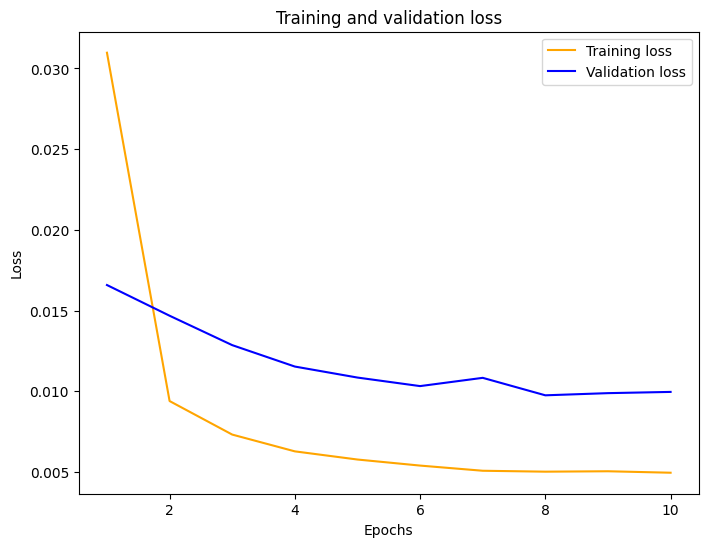

In [15]:
plot_curve(hist)

In [16]:
predict_scaled = model_1.predict(X_test)
predict = sc.inverse_transform(predict_scaled)
predict

2/2 [==============================] - 1s 4ms/step


array([[0.30951494],
       [0.14599875],
       [0.10035008],
       [0.10809848],
       [0.11758267],
       [0.1299785 ],
       [0.15143947],
       [0.15321185],
       [0.15075858],
       [0.18799023],
       [0.2626506 ],
       [0.33981314],
       [0.31692582],
       [0.29070792],
       [0.24807328],
       [0.2860665 ],
       [0.3100069 ],
       [0.43232673],
       [0.29543197],
       [0.57031596],
       [0.6944264 ],
       [0.7266145 ],
       [0.77872497],
       [0.23964621],
       [0.20074023],
       [0.20088927],
       [0.15277474],
       [0.15925659],
       [0.14830242],
       [0.152236  ],
       [0.14356975],
       [0.14639716],
       [0.13797463],
       [0.12701747],
       [0.12524848],
       [0.15216489],
       [0.16065986],
       [0.16414939],
       [0.16438481],
       [0.16669956],
       [0.15933368],
       [0.16282596],
       [0.15669797],
       [0.14284629],
       [0.1534931 ],
       [0.16562548],
       [0.16534269],
       [0.164

In [17]:
train0 = train.copy()
test0 = test.copy()

In [18]:
train0.reset_index(inplace=True)
test0.reset_index(inplace=True)

In [19]:
test0['LSTM'] = predict
test0

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,26.3570,59.4630,1.8078,0.111,0.309515
1,2021-12-16 09:15:00,26.5138,57.7414,1.8068,0.094,0.145999
2,2021-12-16 09:20:00,26.7386,57.1244,1.8530,0.112,0.100350
3,2021-12-16 09:25:00,26.7556,56.6154,1.7632,0.123,0.108098
4,2021-12-16 09:30:00,26.9252,55.9558,1.5730,0.136,0.117583
5,2021-12-16 09:35:00,27.1718,55.0054,1.7632,0.154,0.129978
6,2021-12-16 09:40:00,27.2984,54.1164,1.7462,0.161,0.151439
7,2021-12-16 09:45:00,27.3976,53.6244,1.6644,0.156,0.153212
8,2021-12-16 09:50:00,27.4496,53.0188,1.7654,0.198,0.150759
9,2021-12-16 09:55:00,27.5436,52.6994,1.7786,0.281,0.187990


In [20]:
plot_test(train0,test0)

In [21]:
lstm_mae_error = mae(test0["cloud_cover"], test0["LSTM"])
lstm_mape_error = mape(test0["cloud_cover"], test0["LSTM"])
lstm_mse_error = mean_squared_error(test0['cloud_cover'], test0['LSTM'], squared=True)
lstm_rmse_error = mean_squared_error(test0["cloud_cover"], test0["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error)
print('MAPE Error :  %.5f'%lstm_mape_error)
print('MSE Error : %.5f'%lstm_mse_error)
print('RMSE Error :  %.5f'%lstm_rmse_error)

MAE Error :  0.04290
MAPE Error :  0.18602
MSE Error : 0.00986
RMSE Error :  0.09928


---

## Lag 10

In [22]:
# X_train, y_train, X_test and y_test
X_train1, y_train1, X_test1, y_test1, sc1 = Xtrain_ytrain(train,test,10)

X_train Shape : (2911, 10, 4)
y_train Shape : (2911, 1)
X_test Shape :  (59, 10, 4)
y_test Shape :  (59, 1)


### Add frist layer units = 50 batch size 32  epochs 10

In [23]:
model_2 = Sequential()
model_2.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train1.shape[1],X_train1.shape[2])))
model_2.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_2.compile(optimizer = opt, loss = 'mean_squared_error')
hist1 = model_2.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs = 10, batch_size = 32)

Epoch 1/10
91/91 [==============================] - 3s 15ms/step - loss: 0.0277 - val_loss: 0.0171
Epoch 2/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0082 - val_loss: 0.0139
Epoch 3/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0068 - val_loss: 0.0122
Epoch 4/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0057 - val_loss: 0.0108
Epoch 5/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0053 - val_loss: 0.0112
Epoch 6/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 7/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 8/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 9/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0049 - val_loss: 0.0101
Epoch 10/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0051 - val_loss: 0.0102


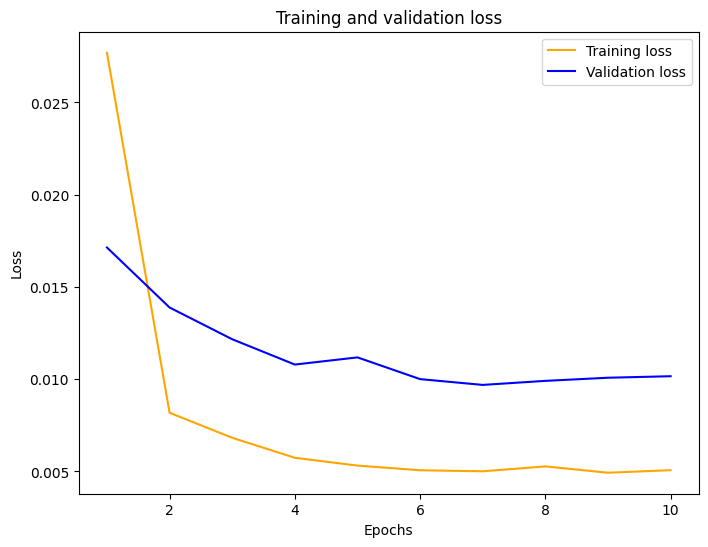

In [24]:
plot_curve(hist1)

In [25]:
predict_scaled1 = model_2.predict(X_test1)
predict1 = sc1.inverse_transform(predict_scaled1)

2/2 [==============================] - 0s 5ms/step


In [26]:
test1 = test.copy()
train1 = train.copy()

In [27]:
train1.reset_index(inplace=True)
test1.reset_index(inplace=True)

In [28]:
test1['LSTM'] = predict1
test1

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,26.3570,59.4630,1.8078,0.111,0.302367
1,2021-12-16 09:15:00,26.5138,57.7414,1.8068,0.094,0.148743
2,2021-12-16 09:20:00,26.7386,57.1244,1.8530,0.112,0.095990
3,2021-12-16 09:25:00,26.7556,56.6154,1.7632,0.123,0.099058
4,2021-12-16 09:30:00,26.9252,55.9558,1.5730,0.136,0.106616
5,2021-12-16 09:35:00,27.1718,55.0054,1.7632,0.154,0.116211
6,2021-12-16 09:40:00,27.2984,54.1164,1.7462,0.161,0.139625
7,2021-12-16 09:45:00,27.3976,53.6244,1.6644,0.156,0.145741
8,2021-12-16 09:50:00,27.4496,53.0188,1.7654,0.198,0.140561
9,2021-12-16 09:55:00,27.5436,52.6994,1.7786,0.281,0.179559


In [29]:
plot_test(train1,test1)

In [30]:
lstm_mae_error1 = mae(test1["cloud_cover"], test1["LSTM"])
lstm_mape_error1 = mape(test1["cloud_cover"], test1["LSTM"])
lstm_mse_error1 = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=True)
lstm_rmse_error1 = mean_squared_error(test1["cloud_cover"], test1["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error1)
print('MAPE Error :  %.5f'%lstm_mape_error1)
print('MSE Error : %.5f'%lstm_mse_error1)
print('RMSE Error :  %.5f'%lstm_rmse_error1)

MAE Error :  0.04823
MAPE Error :  0.21580
MSE Error : 0.01006
RMSE Error :  0.10029


---

## Lag 15

In [31]:
# X_train, y_train, X_test and y_test
X_train2, y_train2, X_test2, y_test2, sc2 = Xtrain_ytrain(train,test,15)

X_train Shape : (2906, 15, 4)
y_train Shape : (2906, 1)
X_test Shape :  (59, 15, 4)
y_test Shape :  (59, 1)


### Optimizer adam first layer 100 batch size 32 epochs 10 

In [32]:
model_3 = Sequential()
model_3.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train2.shape[1],X_train2.shape[2])))
model_3.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_3.compile(optimizer = opt, loss = 'mean_squared_error')
hist2 = model_3.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), epochs = 10, batch_size = 32)

Epoch 1/10
91/91 [==============================] - 3s 15ms/step - loss: 0.0176 - val_loss: 0.0156
Epoch 2/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0070 - val_loss: 0.0133
Epoch 3/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0061 - val_loss: 0.0105
Epoch 4/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0056 - val_loss: 0.0109
Epoch 5/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 6/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0051 - val_loss: 0.0105
Epoch 7/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 8/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0097
Epoch 9/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 10/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 0.0098


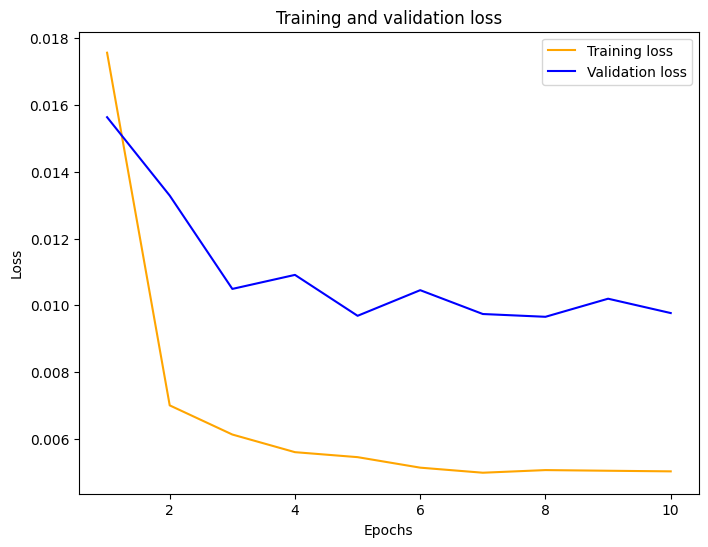

In [33]:
plot_curve(hist2)

In [34]:
predict_scaled2 = model_3.predict(X_test2)
predict2 = sc2.inverse_transform(predict_scaled2)

2/2 [==============================] - 1s 4ms/step


In [35]:
train2 = train.copy()
test2 = test.copy()

In [36]:
train2.reset_index(inplace=True)
test2.reset_index(inplace=True)

In [37]:
test2['LSTM'] = predict2
test2

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,26.3570,59.4630,1.8078,0.111,0.316517
1,2021-12-16 09:15:00,26.5138,57.7414,1.8068,0.094,0.144898
2,2021-12-16 09:20:00,26.7386,57.1244,1.8530,0.112,0.103163
3,2021-12-16 09:25:00,26.7556,56.6154,1.7632,0.123,0.113830
4,2021-12-16 09:30:00,26.9252,55.9558,1.5730,0.136,0.123023
5,2021-12-16 09:35:00,27.1718,55.0054,1.7632,0.154,0.134097
6,2021-12-16 09:40:00,27.2984,54.1164,1.7462,0.161,0.160712
7,2021-12-16 09:45:00,27.3976,53.6244,1.6644,0.156,0.162674
8,2021-12-16 09:50:00,27.4496,53.0188,1.7654,0.198,0.155946
9,2021-12-16 09:55:00,27.5436,52.6994,1.7786,0.281,0.196429


In [38]:
plot_test(train2,test2)

In [39]:
lstm_mae_error2 = mae(test2["cloud_cover"], test2["LSTM"])
lstm_mape_error2 = mape(test2["cloud_cover"], test2["LSTM"])
lstm_mse_error2 = mean_squared_error(test2['cloud_cover'], test2['LSTM'], squared=True)
lstm_rmse_error2 = mean_squared_error(test2["cloud_cover"], test2["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error2)
print('MAPE Error :  %.5f'%lstm_mape_error2)
print('MSE Error : %.5f'%lstm_mse_error2)
print('RMSE Error :  %.5f'%lstm_rmse_error2)

MAE Error :  0.04300
MAPE Error :  0.18848
MSE Error : 0.00967
RMSE Error :  0.09834


---

## Lag 20

In [40]:
# X_train, y_train, X_test and y_test
X_train3, y_train3, X_test3, y_test3, sc3 = Xtrain_ytrain(train,test,20)

X_train Shape : (2901, 20, 4)
y_train Shape : (2901, 1)
X_test Shape :  (59, 20, 4)
y_test Shape :  (59, 1)


### Optimizer adam first layer 50 batch size 32 epochs 10 lr0.005

In [41]:
model_4 = Sequential()
model_4.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train3.shape[1],X_train3.shape[2])))
model_4.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
model_4.compile(optimizer = opt, loss = 'mean_squared_error')
hist3 = model_4.fit(X_train3, y_train3, validation_data=(X_test3, y_test3), epochs = 10, batch_size = 32)

Epoch 1/10
91/91 [==============================] - 3s 15ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 2/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0072 - val_loss: 0.0120
Epoch 3/10
91/91 [==============================] - 1s 10ms/step - loss: 0.0060 - val_loss: 0.0102
Epoch 4/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 5/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0055 - val_loss: 0.0101
Epoch 6/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0052 - val_loss: 0.0098
Epoch 7/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 8/10
91/91 [==============================] - 1s 11ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 9/10
91/91 [==============================] - 1s 10ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 10/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0049 - val_loss: 0.0099


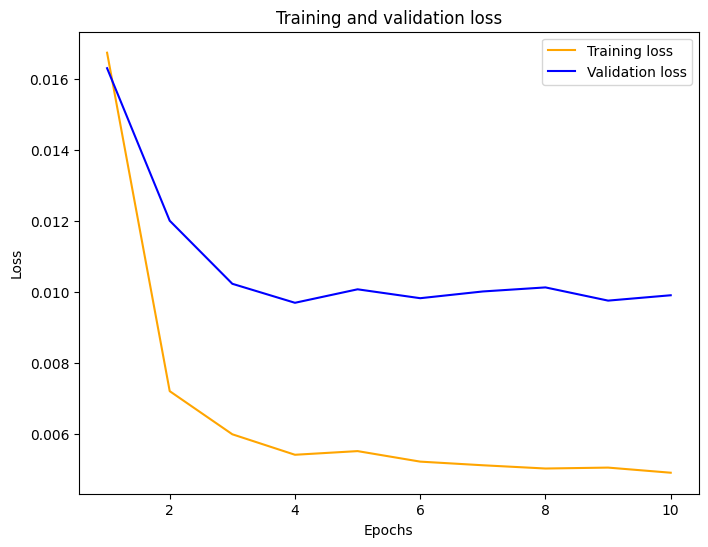

In [42]:
plot_curve(hist3)

In [43]:
predict_scaled3 = model_4.predict(X_test3)
predict3 = sc3.inverse_transform(predict_scaled3)

2/2 [==============================] - 0s 7ms/step


In [44]:
train3 = train.copy()
test3 = test.copy()

In [45]:
train3.reset_index(inplace=True)
test3.reset_index(inplace=True)

In [46]:
test3['LSTM'] = predict3
test3

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,26.3570,59.4630,1.8078,0.111,0.317285
1,2021-12-16 09:15:00,26.5138,57.7414,1.8068,0.094,0.149971
2,2021-12-16 09:20:00,26.7386,57.1244,1.8530,0.112,0.102962
3,2021-12-16 09:25:00,26.7556,56.6154,1.7632,0.123,0.110628
4,2021-12-16 09:30:00,26.9252,55.9558,1.5730,0.136,0.118216
5,2021-12-16 09:35:00,27.1718,55.0054,1.7632,0.154,0.129997
6,2021-12-16 09:40:00,27.2984,54.1164,1.7462,0.161,0.155133
7,2021-12-16 09:45:00,27.3976,53.6244,1.6644,0.156,0.158268
8,2021-12-16 09:50:00,27.4496,53.0188,1.7654,0.198,0.153646
9,2021-12-16 09:55:00,27.5436,52.6994,1.7786,0.281,0.192742


In [47]:
plot_test(train3,test3)

In [48]:
lstm_mae_error3 = mae(test3["cloud_cover"], test3["LSTM"])
lstm_mape_error3 = mape(test3["cloud_cover"], test3["LSTM"])
lstm_mse_error3 = mean_squared_error(test3['cloud_cover'], test3['LSTM'], squared=True)
lstm_rmse_error3 = mean_squared_error(test3["cloud_cover"], test3["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error3)
print('MAPE Error :  %.5f'%lstm_mape_error3)
print('MSE Error : %.5f'%lstm_mse_error3)
print('RMSE Error :  %.5f'%lstm_rmse_error3)

MAE Error :  0.04672
MAPE Error :  0.21496
MSE Error : 0.00980
RMSE Error :  0.09902


---

## Lag 25

In [49]:
# X_train, y_train, X_test and y_test
X_train4, y_train4, X_test4, y_test4, sc4 = Xtrain_ytrain(train,test,25)

X_train Shape : (2896, 25, 4)
y_train Shape : (2896, 1)
X_test Shape :  (59, 25, 4)
y_test Shape :  (59, 1)


### Optimizer adam first layer 100 batch size 32 learning rate 0.005 epochs 20 

In [50]:
model_5 = Sequential()
model_5.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train4.shape[1],X_train4.shape[2])))
model_5.add(Dense(units = 1))
model_5.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist4 = model_5.fit(X_train4, y_train4, validation_data=(X_test4, y_test4), epochs = 20, batch_size = 32)

Epoch 1/20
91/91 [==============================] - 3s 14ms/step - loss: 0.0393 - val_loss: 0.0204
Epoch 2/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0128 - val_loss: 0.0187
Epoch 3/20
91/91 [==============================] - 1s 10ms/step - loss: 0.0107 - val_loss: 0.0179
Epoch 4/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0093 - val_loss: 0.0155
Epoch 5/20
91/91 [==============================] - 1s 12ms/step - loss: 0.0081 - val_loss: 0.0155
Epoch 6/20
91/91 [==============================] - 1s 10ms/step - loss: 0.0074 - val_loss: 0.0134
Epoch 7/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0066 - val_loss: 0.0149
Epoch 8/20
91/91 [==============================] - 1s 12ms/step - loss: 0.0065 - val_loss: 0.0129
Epoch 9/20
91/91 [==============================] - 1s 11ms/step - loss: 0.0056 - val_loss: 0.0109
Epoch 10/20
91/91 [==============================] - 1s 10ms/step - loss: 0.0053 - val_loss: 0.0103
Epoch 11/20


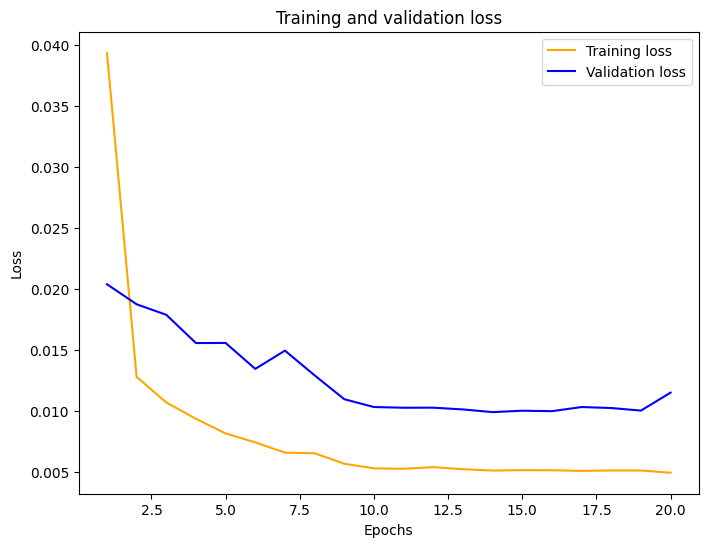

In [51]:
plot_curve(hist4)

In [52]:
predict_scaled4 = model_5.predict(X_test4)
predict4 = sc4.inverse_transform(predict_scaled4)

2/2 [==============================] - 0s 6ms/step


In [53]:
train4 = train.copy()
test4 = test.copy()

In [54]:
train4.reset_index(inplace=True)
test4.reset_index(inplace=True)

In [55]:
test4['LSTM'] = predict4
test4

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,26.3570,59.4630,1.8078,0.111,0.353913
1,2021-12-16 09:15:00,26.5138,57.7414,1.8068,0.094,0.189738
2,2021-12-16 09:20:00,26.7386,57.1244,1.8530,0.112,0.140773
3,2021-12-16 09:25:00,26.7556,56.6154,1.7632,0.123,0.153971
4,2021-12-16 09:30:00,26.9252,55.9558,1.5730,0.136,0.160030
5,2021-12-16 09:35:00,27.1718,55.0054,1.7632,0.154,0.169574
6,2021-12-16 09:40:00,27.2984,54.1164,1.7462,0.161,0.198429
7,2021-12-16 09:45:00,27.3976,53.6244,1.6644,0.156,0.193568
8,2021-12-16 09:50:00,27.4496,53.0188,1.7654,0.198,0.186348
9,2021-12-16 09:55:00,27.5436,52.6994,1.7786,0.281,0.230181


In [56]:
plot_test(train4,test4)

In [57]:
lstm_mae_error4 = mae(test4["cloud_cover"], test4["LSTM"])
lstm_mape_error4 = mape(test4["cloud_cover"], test4["LSTM"])
lstm_mse_error4 = mean_squared_error(test4['cloud_cover'], test4['LSTM'], squared=True)
lstm_rmse_error4 = mean_squared_error(test4["cloud_cover"], test4["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error4)
print('MAPE Error :  %.5f'%lstm_mape_error4)
print('MSE Error : %.5f'%lstm_mse_error4)
print('RMSE Error :  %.5f'%lstm_rmse_error4)

MAE Error :  0.06492
MAPE Error :  0.34690
MSE Error : 0.01136
RMSE Error :  0.10660


---

## Lag 30

In [58]:
# X_train, y_train, X_test and y_test
X_train5, y_train5, X_test5, y_test5, sc5 = Xtrain_ytrain(train,test,30)

X_train Shape : (2891, 30, 4)
y_train Shape : (2891, 1)
X_test Shape :  (59, 30, 4)
y_test Shape :  (59, 1)


### Add frist layer units = 50 batch size 32  epochs 10

In [59]:
model_6 = Sequential()
model_6.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train5.shape[1],X_train5.shape[2])))
model_6.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.05)
model_6.compile(optimizer = opt, loss = 'mean_squared_error')
hist5 = model_6.fit(X_train5, y_train5, validation_data=(X_test5, y_test5), epochs = 20, batch_size = 32)

Epoch 1/20
91/91 [==============================] - 3s 15ms/step - loss: 0.1556 - val_loss: 0.0101
Epoch 2/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0073 - val_loss: 0.0103
Epoch 3/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0086 - val_loss: 0.0118
Epoch 4/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0066 - val_loss: 0.0232
Epoch 5/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0071 - val_loss: 0.0115
Epoch 6/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0085 - val_loss: 0.0168
Epoch 7/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0077 - val_loss: 0.0103
Epoch 8/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0084 - val_loss: 0.0175
Epoch 9/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0070 - val_loss: 0.0109
Epoch 10/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0068 - val_loss: 0.0102
Epoch 11/20
91/91 

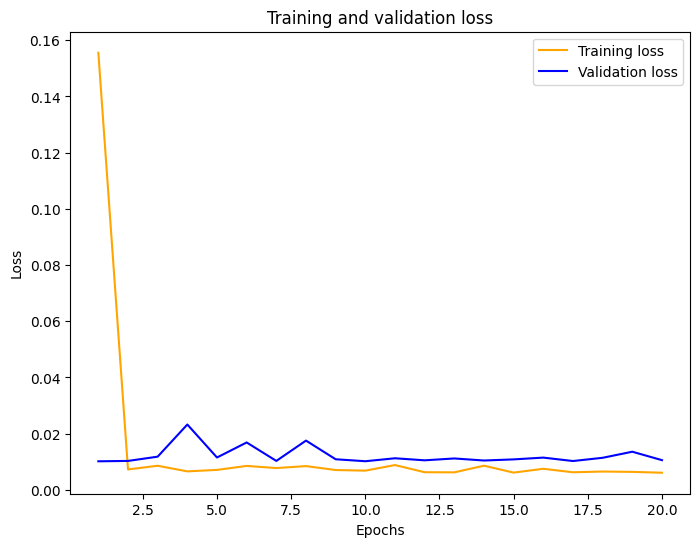

In [60]:
plot_curve(hist5)

In [61]:
predict_scaled5 = model_6.predict(X_test5)
predict5 = sc5.inverse_transform(predict_scaled5)

2/2 [==============================] - 0s 5ms/step


In [62]:
train5 = train.copy()
test5 = test.copy()

In [63]:
train5.reset_index(inplace=True)
test5.reset_index(inplace=True)

In [64]:
test5['LSTM'] = predict5
test5

,DateTime,Temperature,RH,Windspeed,cloud_cover,LSTM
0,2021-12-16 09:10:00,26.3570,59.4630,1.8078,0.111,0.329290
1,2021-12-16 09:15:00,26.5138,57.7414,1.8068,0.094,0.158103
2,2021-12-16 09:20:00,26.7386,57.1244,1.8530,0.112,0.120881
3,2021-12-16 09:25:00,26.7556,56.6154,1.7632,0.123,0.132919
4,2021-12-16 09:30:00,26.9252,55.9558,1.5730,0.136,0.137513
5,2021-12-16 09:35:00,27.1718,55.0054,1.7632,0.154,0.145722
6,2021-12-16 09:40:00,27.2984,54.1164,1.7462,0.161,0.176167
7,2021-12-16 09:45:00,27.3976,53.6244,1.6644,0.156,0.175172
8,2021-12-16 09:50:00,27.4496,53.0188,1.7654,0.198,0.168955
9,2021-12-16 09:55:00,27.5436,52.6994,1.7786,0.281,0.210790


In [65]:
plot_test(train5,test5)

In [66]:
lstm_mae_error5 = mae(test5["cloud_cover"], test5["LSTM"])
lstm_mape_error5 = mape(test5["cloud_cover"], test5["LSTM"])
lstm_mse_error5 = mean_squared_error(test5['cloud_cover'], test5['LSTM'], squared=True)
lstm_rmse_error5 = mean_squared_error(test5["cloud_cover"], test5["LSTM"], squared=False)
print('MAE Error :  %.5f'%lstm_mae_error5)
print('MAPE Error :  %.5f'%lstm_mape_error5)
print('MSE Error : %.5f'%lstm_mse_error5)
print('RMSE Error :  %.5f'%lstm_rmse_error5)

MAE Error :  0.05045
MAPE Error :  0.24564
MSE Error : 0.01045
RMSE Error :  0.10223


---

# error

## avg mae

In [67]:
avgmse = (lstm_mae_error+lstm_mae_error1+lstm_mae_error2+lstm_mae_error3+lstm_mae_error4+lstm_mae_error5)/6
print("AVG MAE : %.5f"%avgmse)

AVG MAE : 0.04937


---

## avg mape

In [68]:
avgmape = (lstm_mape_error+lstm_mape_error1+lstm_mape_error2+lstm_mape_error3+lstm_mape_error4+lstm_mape_error5)/6
print("AVG MAPE : %.5f"%avgmape)

AVG MAPE : 0.23297


---

## avg mse

In [69]:
avgmse = (lstm_mse_error+lstm_mse_error1+lstm_mse_error2+lstm_mse_error3+lstm_mse_error4+lstm_mse_error5)/6
print("AVG MSE :%.5f"%avgmse)

AVG MSE :0.01020


---

## avg rmse

In [70]:
avgrmse = (lstm_rmse_error+lstm_rmse_error1+lstm_rmse_error2+lstm_rmse_error3+lstm_rmse_error4+lstm_rmse_error5)/6
print("AVG RMSE : %.5f"%avgrmse)

AVG RMSE : 0.10096


---